### DCGAN

This notebook experiment is on DCGAN. The source code fot his experiment is based on PyTorch implementation of DCGAN.

source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
from torchvision.utils import make_grid
torch.manual_seed(manualSeed)
from dcgan_network import Generator, Discriminator

Random Seed:  999


#### Helper function to display image

In [2]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.figure(figsize=(8,8))
    if show:
        plt.show()
        
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/0/%d.png" % batches_done, nrow=n_row, normalize=True)

# Create folder to save generated images
DATAGEN_FOLDER = "gen_images/"
if not os.path.isdir(DATAGEN_FOLDER):
    os.mkdir(DATAGEN_FOLDER)

# Create folder to save model
MODEL_FOLDER = "Model"
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)

#### Initilization

In [3]:
# Root directory for dataset
dataroot = "data/train/"

import os

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

#### Data

The data for this experiment is assumed to be in the root folder under data directory. 
Train: data/train
Val: data/val
Test: data/test

For the purpose of this experiment, only the treain data was used

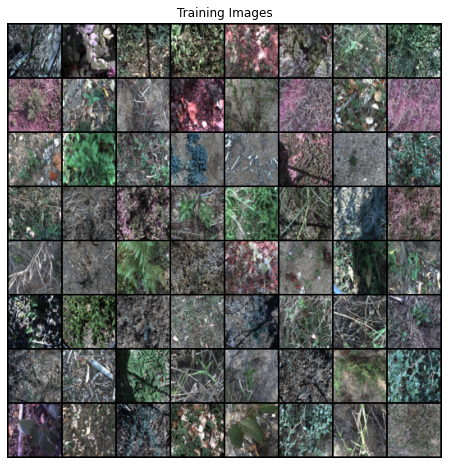

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Implementation

#### Weight Initialization

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### Generator

In [6]:
# Create the generator
netG = Generator(ngpu, nz, ngf, nc).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#### Discriminator

In [7]:
# Create the Discriminator
netD = Discriminator(ngpu, nc, ndf).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


#### Loss Function and Optimizers

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

In [9]:
# Training Loop



# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/200][0/137]	Loss_D: 1.6524	Loss_G: 6.9266	D(x): 0.5767	D(G(z)): 0.5731 / 0.0015
[0/200][50/137]	Loss_D: 2.1275	Loss_G: 10.3286	D(x): 0.7190	D(G(z)): 0.7423 / 0.0002
[0/200][100/137]	Loss_D: 0.9830	Loss_G: 2.8670	D(x): 0.6247	D(G(z)): 0.3482 / 0.0714
[1/200][0/137]	Loss_D: 0.7612	Loss_G: 3.5818	D(x): 0.7619	D(G(z)): 0.3302 / 0.0396
[1/200][50/137]	Loss_D: 0.3113	Loss_G: 4.5596	D(x): 0.8834	D(G(z)): 0.1546 / 0.0167
[1/200][100/137]	Loss_D: 0.3191	Loss_G: 3.9355	D(x): 0.8620	D(G(z)): 0.1413 / 0.0254
[2/200][0/137]	Loss_D: 0.8944	Loss_G: 6.8581	D(x): 0.4774	D(G(z)): 0.0015 / 0.0021
[2/200][50/137]	Loss_D: 0.2295	Loss_G: 3.7200	D(x): 0.8834	D(G(z)): 0.0900 / 0.0336
[2/200][100/137]	Loss_D: 0.4204	Loss_G: 10.9282	D(x): 0.9039	D(G(z)): 0.1926 / 0.0000
[3/200][0/137]	Loss_D: 0.1886	Loss_G: 5.9057	D(x): 0.9121	D(G(z)): 0.0808 / 0.0036
[3/200][50/137]	Loss_D: 0.6177	Loss_G: 4.9157	D(x): 0.6270	D(G(z)): 0.0295 / 0.0167
[3/200][100/137]	Loss_D: 0.5713	Loss_G: 3.2157	D(

[32/200][50/137]	Loss_D: 0.5866	Loss_G: 4.2733	D(x): 0.8268	D(G(z)): 0.2792 / 0.0212
[32/200][100/137]	Loss_D: 0.8745	Loss_G: 3.4077	D(x): 0.7156	D(G(z)): 0.3452 / 0.0489
[33/200][0/137]	Loss_D: 0.7840	Loss_G: 2.6867	D(x): 0.6281	D(G(z)): 0.2006 / 0.1000
[33/200][50/137]	Loss_D: 0.7777	Loss_G: 4.8479	D(x): 0.8468	D(G(z)): 0.3933 / 0.0125
[33/200][100/137]	Loss_D: 0.6925	Loss_G: 3.6170	D(x): 0.8492	D(G(z)): 0.3599 / 0.0394
[34/200][0/137]	Loss_D: 0.4752	Loss_G: 3.2303	D(x): 0.7832	D(G(z)): 0.1779 / 0.0538
[34/200][50/137]	Loss_D: 0.7506	Loss_G: 4.1313	D(x): 0.7573	D(G(z)): 0.3269 / 0.0235
[34/200][100/137]	Loss_D: 0.8745	Loss_G: 4.1387	D(x): 0.7048	D(G(z)): 0.3324 / 0.0237
[35/200][0/137]	Loss_D: 0.6719	Loss_G: 3.0393	D(x): 0.6668	D(G(z)): 0.1628 / 0.0732
[35/200][50/137]	Loss_D: 1.2788	Loss_G: 1.5435	D(x): 0.3708	D(G(z)): 0.0085 / 0.3373
[35/200][100/137]	Loss_D: 0.8053	Loss_G: 4.7288	D(x): 0.8589	D(G(z)): 0.4187 / 0.0154
[36/200][0/137]	Loss_D: 1.0307	Loss_G: 1.5611	D(x): 0.4809	D(G(z

[64/200][100/137]	Loss_D: 0.6857	Loss_G: 5.7884	D(x): 0.8684	D(G(z)): 0.3620 / 0.0051
[65/200][0/137]	Loss_D: 0.3069	Loss_G: 4.3690	D(x): 0.8399	D(G(z)): 0.0980 / 0.0221
[65/200][50/137]	Loss_D: 0.9058	Loss_G: 2.3020	D(x): 0.5190	D(G(z)): 0.0351 / 0.1784
[65/200][100/137]	Loss_D: 0.5383	Loss_G: 5.6298	D(x): 0.9072	D(G(z)): 0.3028 / 0.0058
[66/200][0/137]	Loss_D: 0.6816	Loss_G: 6.5855	D(x): 0.9782	D(G(z)): 0.3942 / 0.0027
[66/200][50/137]	Loss_D: 0.6021	Loss_G: 3.6071	D(x): 0.6208	D(G(z)): 0.0190 / 0.0609
[66/200][100/137]	Loss_D: 0.8064	Loss_G: 3.3256	D(x): 0.5447	D(G(z)): 0.0195 / 0.0756
[67/200][0/137]	Loss_D: 0.7308	Loss_G: 6.7885	D(x): 0.9539	D(G(z)): 0.4326 / 0.0017
[67/200][50/137]	Loss_D: 0.3714	Loss_G: 4.1217	D(x): 0.7692	D(G(z)): 0.0572 / 0.0297
[67/200][100/137]	Loss_D: 0.2823	Loss_G: 3.7457	D(x): 0.8682	D(G(z)): 0.1123 / 0.0391
[68/200][0/137]	Loss_D: 1.0640	Loss_G: 6.9779	D(x): 0.9806	D(G(z)): 0.4542 / 0.0024
[68/200][50/137]	Loss_D: 0.5771	Loss_G: 2.9186	D(x): 0.7121	D(G(z

[97/200][0/137]	Loss_D: 0.4237	Loss_G: 4.4312	D(x): 0.9414	D(G(z)): 0.2525 / 0.0189
[97/200][50/137]	Loss_D: 0.2955	Loss_G: 3.2203	D(x): 0.8931	D(G(z)): 0.1494 / 0.0579
[97/200][100/137]	Loss_D: 0.6543	Loss_G: 2.0715	D(x): 0.6046	D(G(z)): 0.0229 / 0.2015
[98/200][0/137]	Loss_D: 0.6002	Loss_G: 6.7504	D(x): 0.9786	D(G(z)): 0.3698 / 0.0022
[98/200][50/137]	Loss_D: 0.2715	Loss_G: 3.6451	D(x): 0.8435	D(G(z)): 0.0685 / 0.0514
[98/200][100/137]	Loss_D: 0.2516	Loss_G: 3.2657	D(x): 0.8743	D(G(z)): 0.0938 / 0.0578
[99/200][0/137]	Loss_D: 0.3518	Loss_G: 4.1049	D(x): 0.9048	D(G(z)): 0.1846 / 0.0261
[99/200][50/137]	Loss_D: 0.3839	Loss_G: 2.8444	D(x): 0.7702	D(G(z)): 0.0744 / 0.0879
[99/200][100/137]	Loss_D: 1.2515	Loss_G: 3.2732	D(x): 0.4184	D(G(z)): 0.0210 / 0.1318
[100/200][0/137]	Loss_D: 0.4106	Loss_G: 5.1519	D(x): 0.9081	D(G(z)): 0.2242 / 0.0097
[100/200][50/137]	Loss_D: 0.3662	Loss_G: 2.6305	D(x): 0.7955	D(G(z)): 0.0905 / 0.1163
[100/200][100/137]	Loss_D: 0.3507	Loss_G: 3.4265	D(x): 0.8143	D(

[129/200][0/137]	Loss_D: 0.1932	Loss_G: 4.3316	D(x): 0.9391	D(G(z)): 0.1099 / 0.0224
[129/200][50/137]	Loss_D: 0.1561	Loss_G: 4.3743	D(x): 0.9576	D(G(z)): 0.0978 / 0.0217
[129/200][100/137]	Loss_D: 0.2811	Loss_G: 4.4540	D(x): 0.9644	D(G(z)): 0.1747 / 0.0187
[130/200][0/137]	Loss_D: 0.1229	Loss_G: 4.4863	D(x): 0.9274	D(G(z)): 0.0419 / 0.0227
[130/200][50/137]	Loss_D: 0.1432	Loss_G: 3.8890	D(x): 0.9257	D(G(z)): 0.0551 / 0.0355
[130/200][100/137]	Loss_D: 0.1737	Loss_G: 4.6905	D(x): 0.9508	D(G(z)): 0.0995 / 0.0148
[131/200][0/137]	Loss_D: 0.1949	Loss_G: 4.9319	D(x): 0.9621	D(G(z)): 0.1316 / 0.0105
[131/200][50/137]	Loss_D: 0.1899	Loss_G: 4.2538	D(x): 0.9040	D(G(z)): 0.0720 / 0.0267
[131/200][100/137]	Loss_D: 0.2753	Loss_G: 5.6958	D(x): 0.9749	D(G(z)): 0.1872 / 0.0059
[132/200][0/137]	Loss_D: 0.1751	Loss_G: 4.8328	D(x): 0.9311	D(G(z)): 0.0842 / 0.0141
[132/200][50/137]	Loss_D: 0.1152	Loss_G: 4.3480	D(x): 0.9667	D(G(z)): 0.0721 / 0.0223
[132/200][100/137]	Loss_D: 1.2214	Loss_G: 2.9208	D(x): 

[161/200][0/137]	Loss_D: 0.1054	Loss_G: 5.1256	D(x): 0.9197	D(G(z)): 0.0169 / 0.0130
[161/200][50/137]	Loss_D: 0.1349	Loss_G: 3.6328	D(x): 0.9281	D(G(z)): 0.0531 / 0.0474
[161/200][100/137]	Loss_D: 0.1178	Loss_G: 3.9874	D(x): 0.9146	D(G(z)): 0.0230 / 0.0426
[162/200][0/137]	Loss_D: 0.0679	Loss_G: 4.9886	D(x): 0.9703	D(G(z)): 0.0343 / 0.0151
[162/200][50/137]	Loss_D: 0.1003	Loss_G: 4.3345	D(x): 0.9373	D(G(z)): 0.0319 / 0.0265
[162/200][100/137]	Loss_D: 0.0964	Loss_G: 4.9918	D(x): 0.9717	D(G(z)): 0.0565 / 0.0136
[163/200][0/137]	Loss_D: 0.1468	Loss_G: 5.6470	D(x): 0.9900	D(G(z)): 0.1124 / 0.0057
[163/200][50/137]	Loss_D: 0.0910	Loss_G: 3.9640	D(x): 0.9408	D(G(z)): 0.0260 / 0.0335
[163/200][100/137]	Loss_D: 0.0952	Loss_G: 4.1301	D(x): 0.9384	D(G(z)): 0.0277 / 0.0293
[164/200][0/137]	Loss_D: 11.6376	Loss_G: 0.0037	D(x): 0.0003	D(G(z)): 0.0001 / 0.9964
[164/200][50/137]	Loss_D: 2.5906	Loss_G: 1.1679	D(x): 0.2646	D(G(z)): 0.1242 / 0.5196
[164/200][100/137]	Loss_D: 0.8951	Loss_G: 3.4965	D(x):

[193/200][0/137]	Loss_D: 0.1199	Loss_G: 5.7372	D(x): 0.9893	D(G(z)): 0.0958 / 0.0050
[193/200][50/137]	Loss_D: 0.0816	Loss_G: 5.1829	D(x): 0.9791	D(G(z)): 0.0551 / 0.0099
[193/200][100/137]	Loss_D: 0.0800	Loss_G: 4.7468	D(x): 0.9675	D(G(z)): 0.0405 / 0.0155
[194/200][0/137]	Loss_D: 0.0859	Loss_G: 5.2934	D(x): 0.9717	D(G(z)): 0.0504 / 0.0098
[194/200][50/137]	Loss_D: 0.0565	Loss_G: 4.9988	D(x): 0.9807	D(G(z)): 0.0344 / 0.0129
[194/200][100/137]	Loss_D: 0.0643	Loss_G: 5.1452	D(x): 0.9731	D(G(z)): 0.0342 / 0.0116
[195/200][0/137]	Loss_D: 0.1428	Loss_G: 6.3115	D(x): 0.9927	D(G(z)): 0.1078 / 0.0028
[195/200][50/137]	Loss_D: 1.4565	Loss_G: 5.9566	D(x): 0.8189	D(G(z)): 0.4605 / 0.0143
[195/200][100/137]	Loss_D: 0.4129	Loss_G: 4.0878	D(x): 0.8500	D(G(z)): 0.1401 / 0.0361
[196/200][0/137]	Loss_D: 0.2004	Loss_G: 5.7724	D(x): 0.9587	D(G(z)): 0.1238 / 0.0056
[196/200][50/137]	Loss_D: 0.1351	Loss_G: 4.7552	D(x): 0.9550	D(G(z)): 0.0756 / 0.0157
[196/200][100/137]	Loss_D: 0.1322	Loss_G: 4.6767	D(x): 

In [10]:
# Saving the generator model
PATH_TO_MODEL = MODEL_FOLDER + "/deepweeds_DCGAN_gan_0.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(netG.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))

Model saved at Model/deepweeds_DCGAN_gan_0.pth


### Evaluate

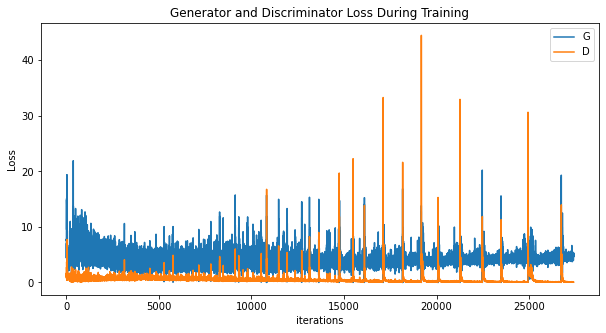

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Following codes are to display various image samples and save for presentation

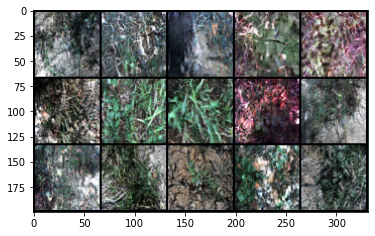

<Figure size 576x576 with 0 Axes>

In [12]:
#View some genaretd images
noise = torch.randn(15, nz, 1, 1, device=device)
        # Generate fake image batch with G
fake = netG(noise)
show_tensor_images(fake, 102)

In [13]:
#

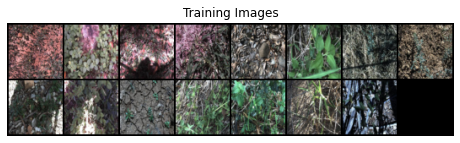

In [14]:
# Plot and save training images for powerpoint slide
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:15], padding=2, normalize=True).cpu(),(1,2,0)))